# EE399 HW6
## Ziwen


https://github.com/ZiwenLi0325/EE399.git

In [1]:
!git clone https://github.com/shervinsahba/pyshred


fatal: destination path 'pyshred' already exists and is not an empty directory.


In [2]:
%cd pyshred

/content/pyshred


In [3]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat
from scipy.io import loadmat

In [4]:
num_sensors = 3 
lags = 52
load_X = load_data("SST")
print(load_X.shape)
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)



(1400, 44219)


In [5]:
### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

epoch: 700 valid_error: tensor(0.1114, device='cuda:0'):  70%|██████▉   | 699/1000 [01:50<00:47,  6.30it/s]


In [6]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.020193104


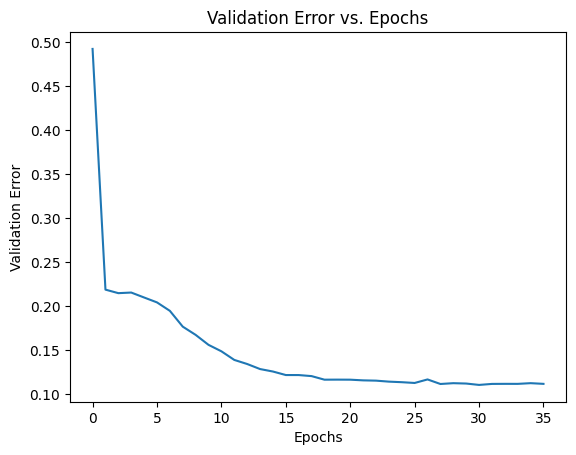

In [7]:
plt.plot(range(len(validation_errors)), validation_errors)
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.title('Validation Error vs. Epochs')
plt.savefig('SST_validation_error.png') 
plt.show()

In [9]:
lag_values = [10, 20, 30, 40, 50]  # Define a list of different lags values
performance_lag = []

for lags in lag_values:
    print(f"Processing time lag: {lags}") 
    # Generate input sequences to SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(n - lags):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]


    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Compute reconstruction error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    # Store performance metric for current time lag value
    performance_lag.append(reconstruction_error)




Processing time lag: 10


epoch: 1000 valid_error: tensor(0.1273, device='cuda:0'): 100%|██████████| 1000/1000 [02:32<00:00,  6.54it/s]


Processing time lag: 20


epoch: 1000 valid_error: tensor(0.1127, device='cuda:0'): 100%|██████████| 1000/1000 [02:33<00:00,  6.53it/s]


Processing time lag: 30


epoch: 980 valid_error: tensor(0.1096, device='cuda:0'):  98%|█████████▊| 979/1000 [02:31<00:03,  6.46it/s]


Processing time lag: 40


epoch: 760 valid_error: tensor(0.1114, device='cuda:0'):  76%|███████▌  | 759/1000 [01:58<00:37,  6.39it/s]


Processing time lag: 50


epoch: 1000 valid_error: tensor(0.1079, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


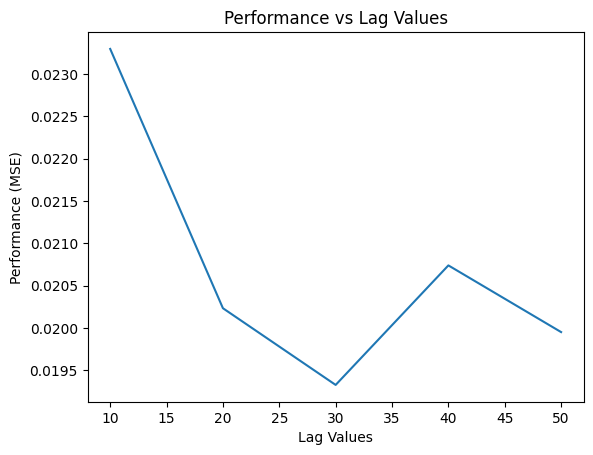

In [13]:
# Plotting
plt.plot(lag_values, performance_lag)
plt.xlabel('Lag Values')
plt.ylabel('Performance (MSE)')
plt.title('Performance vs Lag Values')
plt.savefig('lag_performance.png')
plt.show()

In [15]:
# Define different scales of noise you want to test
noise_scales = [0.0, 0.1, 0.2, 0.5, 1.0, 2.0]

# Define a list to store the performance results for each noise scale
performance_results_noise = []

for noise_level in noise_scales:
    print(f"Processing noise level: {noise_level}")

    # Add Gaussian noise to the data
    noisy_load_X = load_X + np.random.normal(loc=0, scale=noise_level, size=load_X.shape)

    # Normalize the noisy data
    sc = MinMaxScaler()
    sc.fit(noisy_load_X[train_indices])
    transformed_X = sc.transform(noisy_load_X)

    # Generate input sequences to SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(n - lags):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]


    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Compute reconstruction error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    # Store performance metric for current noise level
    performance_results_noise.append(reconstruction_error)



Processing noise level: 0.0


epoch: 920 valid_error: tensor(0.1077, device='cuda:0'):  92%|█████████▏| 919/1000 [02:28<00:13,  6.18it/s]


Processing noise level: 0.1


epoch: 740 valid_error: tensor(0.1237, device='cuda:0'):  74%|███████▍  | 739/1000 [01:57<00:41,  6.31it/s]


Processing noise level: 0.2


epoch: 920 valid_error: tensor(0.1376, device='cuda:0'):  92%|█████████▏| 919/1000 [02:24<00:12,  6.34it/s]


Processing noise level: 0.5


epoch: 580 valid_error: tensor(0.1831, device='cuda:0'):  58%|█████▊    | 579/1000 [01:31<01:06,  6.33it/s]


Processing noise level: 1.0


epoch: 500 valid_error: tensor(0.2293, device='cuda:0'):  50%|████▉     | 499/1000 [01:18<01:19,  6.33it/s]


Processing noise level: 2.0


epoch: 340 valid_error: tensor(0.2645, device='cuda:0'):  34%|███▍      | 339/1000 [00:53<01:44,  6.31it/s]


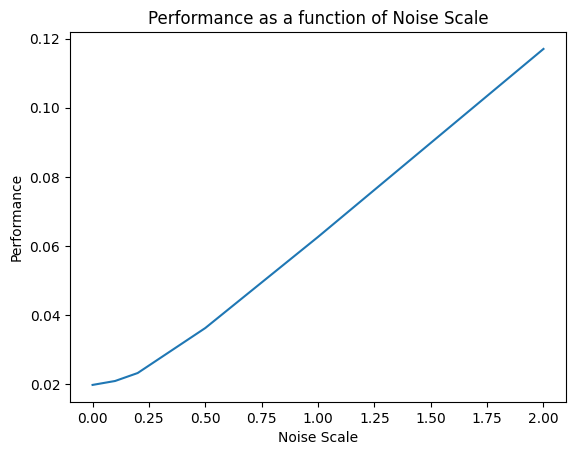

In [16]:
# Plot the performance results as a function of the noise scale
plt.plot(noise_scales, performance_results_noise)
plt.xlabel('Noise Scale')
plt.ylabel('Performance')
plt.title('Performance as a function of Noise Scale')
plt.savefig('noise_scale_performance.png')
plt.show()

In [17]:
# Define different numbers of sensors to test
sensor_counts = range(1, num_sensors+1)

# Define a list to store the performance results for each number of sensors
performance_results_sensor = []

for num_sensors in sensor_counts:
    print(f"Processing number of sensors: {num_sensors}")

    # Update the number of sensors in the code
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
    
    # Generate input sequences to the SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(n - lags):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
    
    # Generate training, validation, and test datasets for state reconstruction and sensor forecasting
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)
    
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)
    
    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Compute reconstruction error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    # Store performance metric for current number of sensors
    performance_results_sensor.append(reconstruction_error)


Processing number of sensors: 1


epoch: 480 valid_error: tensor(0.2692, device='cuda:0'):  48%|████▊     | 479/1000 [01:15<01:21,  6.37it/s]


Processing number of sensors: 2


epoch: 280 valid_error: tensor(0.2632, device='cuda:0'):  28%|██▊       | 279/1000 [00:44<01:53,  6.33it/s]


Processing number of sensors: 3


epoch: 340 valid_error: tensor(0.2639, device='cuda:0'):  34%|███▍      | 339/1000 [00:53<01:44,  6.32it/s]


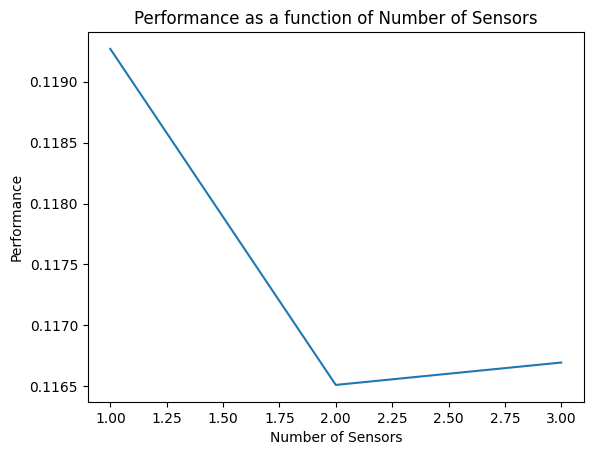

In [18]:
# Plot the performance results as a function of the number of sensors
plt.plot(sensor_counts, performance_results_sensor)
plt.xlabel('Number of Sensors')
plt.ylabel('Performance')
plt.title('Performance as a function of Number of Sensors')
plt.savefig('performance_Sensors.png')
plt.show()